In [42]:
import torch
import torch.nn as nn

# 获取所有可用的 GPU
gpus = torch.cuda.device_count()
print('Number of GPUs available:', gpus)

if gpus > 0:
    gpu_num = 0  # 要使用的 GPU 编号

    # 设置默认的 GPU
    torch.cuda.set_device(gpu_num)
    print('Only GPU number', gpu_num, 'used.')

    # 设置 GPU 内存增长模式
    device = torch.device(f'cuda:{gpu_num}')
    print(device)
    torch.cuda.empty_cache()
    try:
        torch.cuda.memory_allocated = 0
        torch.cuda.memory_reserved = 0
    except RuntimeError as e:
        print(e)


Number of GPUs available: 1
Only GPU number 0 used.
cuda:0


In [76]:
class BinarySource(nn.Module):
    """
    Layer generating random binary tensors.

    Parameters
    ----------
    dtype : torch.dtype
        Defines the output datatype of the layer.
        Defaults to `torch.float32`.

    seed : int or None
        Set the seed for the random generator used to generate the bits.
        Set to `None` for random initialization of the RNG.

    device : torch.device or None
        The device on which the tensor will be created.
        Defaults to `None`, which means the tensor will be created on the CPU.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor filled with random binary values.
    """
    def __init__(self, dtype=torch.float32, seed=None, device=None, **kwargs):
        super().__init__(**kwargs)
        self.dtype = dtype
        self._seed = seed
        self.device = device if device is not None else torch.device('cpu')
        self._rng = torch.Generator(device=self.device)
        if self._seed is not None:
            self._rng.manual_seed(self._seed)

    def forward(self, inputs):
        if self._seed is not None:
            return torch.randint(0, 2, tuple(inputs.tolist()), generator=self._rng, dtype=torch.int32, device=self.device).to(self.dtype)
        else:
            return torch.randint(0, 2, tuple(inputs.tolist()), dtype=torch.int32, device=self.device).to(self.dtype)

In [84]:
def test_binary_source():
    dtype = torch.float32
    seed = 42
    output_shape = [2, 3]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建 BinarySource 实例
    binary_source = BinarySource(dtype=dtype, seed=seed, device=device)

    # 执行前向传播
    inputs = torch.tensor(output_shape, dtype=torch.int32)
    outputs = binary_source(inputs)

    # 输出结果
    print(f"Binary Tensor: {outputs}")

# 运行测试函数
test_binary_source()


Binary Tensor: tensor([[1., 1., 0.],
        [0., 1., 1.]], device='cuda:0')


# torch


In [55]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# import my_code.mysionna as sn

import torch

def gather_pytorch(input_data,  axis=0, indices=None):
    if axis < 0:
        axis = len(input_data.shape) + axis
        
    data = torch.index_select(input_data, axis, indices.flatten())

    shape_input = list(input_data.shape)
    # shape_ = delete(shape_input, axis)
    
    # 连接列表
    shape_output = shape_input[:axis] + \
        list(indices.shape) + shape_input[axis + 1:]

    data_output = data.reshape(shape_output)

    return data_output
def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c


class Constellation(nn.Module):
    def __init__(self,
                 constellation_type,
                 num_bits_per_symbol,
                 initial_value=None,
                 normalize=True,
                 center=False,
                 trainable=False,
                 dtype=torch.complex64,
                 device='cuda',
                 **kwargs):
        super(Constellation, self).__init__()
        assert dtype in [torch.complex64, torch.complex128],\
            "dtype must be torch.complex64 or torch.complex128"
        self._dtype = dtype
        self.device = device

        # 获得 real_dtype
        if dtype == torch.complex64:
            real_dtype = torch.float32
        elif dtype == torch.complex128:
            real_dtype = torch.float64
        else:
            raise TypeError("dtype must be torch.complex64 or torch.complex128")
        # 检查参数异常
        assert constellation_type in ("qam", "pam", "custom"),\
            "Wrong constellation type"
        self._constellation_type = constellation_type

        assert isinstance(normalize, bool), "normalize must be boolean"
        self._normalize = normalize

        assert isinstance(center, bool), "center must be boolean"
        self._center = center

        assert isinstance(trainable, bool), "trainable must be boolean"
        self._trainable = trainable

        assert isinstance(num_bits_per_symbol, (float, int)),\
            "num_bits_per_symbol must be integer"
        assert (num_bits_per_symbol % 1 == 0),\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        #不同的 constellation_type
        if self._constellation_type == "qam":
            assert num_bits_per_symbol % 2 == 0 and num_bits_per_symbol > 0,\
                "num_bits_per_symbol must be a multiple of 2"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "QAM must not have an initial value"
            points = qam(self._num_bits_per_symbol, normalize=self._normalize)
            if not isinstance(points,torch.Tensor):
                points = torch.tensor(points)
            points = points.to(self._dtype).to(self.device)

        elif self._constellation_type == "pam":
            assert num_bits_per_symbol > 0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = num_bits_per_symbol

            assert initial_value is None, "PAM must not have an initial value"
            points = pam(self._num_bits_per_symbol, normalize=self._normalize)
            if not isinstance(points,torch.Tensor):
                points = torch.tensor(points)
            points = points.to(self._dtype).to(self.device)

        elif self._constellation_type == "custom":
            assert num_bits_per_symbol > 0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            if initial_value is None:
                points = torch.rand(2, 2 ** self._num_bits_per_symbol, dtype=real_dtype, device=self.device) * 0.1 - 0.05
                points = torch.complex(points[0], points[1])
            else:
                if not isinstance(initial_value,torch.Tensor):
                    initial_value = torch.tensor(initial_value)
                assert initial_value.dim().numpy()== 1
                assert initial_value.shape[0] == 2 ** num_bits_per_symbol,\
                    "initial_value must have shape [2**num_bits_per_symbol]"
                points = initial_value.to(self._dtype).to(self.device)
        self._points = points

        if self._trainable:
            self._points = nn.Parameter(self._points)
    # pylint: disable=no-self-argument
    def create_or_check_constellation(  constellation_type=None,
                                        num_bits_per_symbol=None,
                                        constellation=None,
                                        dtype=torch.complex64):
        # pylint: disable=line-too-long
        r"""Static method for conviently creating a constellation object or checking that an existing one
        is consistent with requested settings.

        If ``constellation`` is `None`, then this method creates a :class:`~sionna.mapping.Constellation`
        object of type ``constellation_type`` and with ``num_bits_per_symbol`` bits per symbol.
        Otherwise, this method checks that `constellation` is consistent with ``constellation_type`` and
        ``num_bits_per_symbol``. If it is, ``constellation`` is returned. Otherwise, an assertion is raised.

        Input
        ------
        constellation_type : One of ["qam", "pam", "custom"], str
            For "custom", an instance of :class:`~sionna.mapping.Constellation`
            must be provided.

        num_bits_per_symbol : int
            The number of bits per constellation symbol, e.g., 4 for QAM16.
            Only required for ``constellation_type`` in ["qam", "pam"].

        constellation :  Constellation
            An instance of :class:`~sionna.mapping.Constellation` or
            `None`. In the latter case, ``constellation_type``
            and ``num_bits_per_symbol`` must be provided.

        Output
        -------
        : :class:`~sionna.mapping.Constellation`
            A constellation object.
        """
        constellation_object = None
        if constellation is not None:
            assert constellation_type in [None, "custom"], \
                """`constellation_type` must be "custom"."""
            assert num_bits_per_symbol in \
                     [None, constellation.num_bits_per_symbol], \
                """`Wrong value of `num_bits_per_symbol.`"""
            assert constellation.dtype==dtype, \
                "Constellation has wrong dtype."
            constellation_object = constellation
        else:
            assert constellation_type in ["qam", "pam"], \
                "Wrong constellation type."
            assert num_bits_per_symbol is not None, \
                "`num_bits_per_symbol` must be provided."
            constellation_object = Constellation(   constellation_type,
                                                    num_bits_per_symbol,
                                                    dtype=dtype)
        return constellation_object
    def forward(self, x):
        x = self._points
        if self._center:
            x = x - x.mean()
        if self._normalize:
            energy = (x.abs() ** 2).mean()
            energy_sqrt = torch.sqrt(energy).to(self._dtype)
            x = x / energy_sqrt
        return x

    @property
    def normalize(self):
        """Indicates if the constellation is normalized or not."""
        return self._normalize

    @normalize.setter
    def normalize(self, value):
        assert isinstance(value, bool), "`normalize` must be boolean"
        self._normalize = value

    @property
    def center(self):
        """Indicates if the constellation is centered."""
        return self._center

    @center.setter
    def center(self, value):
        assert isinstance(value, bool), "`center` must be boolean"
        self._center = value

    @property
    def num_bits_per_symbol(self):
        """The number of bits per constellation symbol."""
        return self._num_bits_per_symbol
    
    @property
    def dtype(self):
        return self._dtype

    @property
    def points(self):
        """The (possibly) centered and normalized constellation points."""
        return self(None)

    def show(self, labels=True, figsize=(7,7)):
        """Generate a scatter-plot of the constellation.

        Input
        -----
        labels : bool
            If `True`, the bit labels will be drawn next to each constellation
            point. Defaults to `True`.

        figsize : Two-element Tuple, float
            Width and height in inches. Defaults to `(7,7)`.

        Output
        ------
        : matplotlib.figure.Figure
            A handle to a matplot figure object.
        """
        maxval = self._points.abs().max().item() * 1.05
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(-maxval, maxval)
        ax.set_ylim(-maxval, maxval)
        points_cpu = self._points.detach().cpu().numpy()
        ax.scatter(points_cpu.real, points_cpu.imag)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("Real Part")
        ax.set_ylabel("Imaginary Part")
        ax.grid(True, which="both", axis="both")
        ax.set_title("Constellation Plot")
        if labels:
            for j, p in enumerate(points_cpu):
                ax.annotate(
                    format(j, f'0{self._num_bits_per_symbol}b'),
                    (p.real, p.imag)
                )
        plt.show()
        
class Mapper(nn.Module):
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 dtype=torch.complex64,
                 device='cuda'):
        super(Mapper, self).__init__()

        assert dtype in [torch.complex64, torch.complex128], "dtype must be torch.complex64 or torch.complex128"

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

        self._return_indices = return_indices
        self.device = device

        self._binary_base = 2**torch.arange(self._constellation.num_bits_per_symbol-1, -1, -1, device=device, dtype=torch.int32)

    @property
    def constellation(self):
        """The Constellation used by the Mapper."""
        return self._constellation

    def forward(self, inputs):
        if not isinstance(inputs,torch.Tensor):
            inputs = torch.tensor(inputs)
        assert inputs.dim() >= 2, "The input must have at least rank 2"

        # Reshape inputs to the desired format
        new_shape = list(inputs.shape[:-1]) + [int(inputs.shape[-1] / self.constellation.num_bits_per_symbol), self.constellation.num_bits_per_symbol]
        inputs_reshaped = inputs.view(new_shape).to(torch.int32)

        # Convert the last dimension to an integer
        int_rep = torch.sum(inputs_reshaped * self._binary_base, dim=-1)
        # Map integers to constellation symbols
        x = gather_pytorch(self.constellation.points,axis=0,indices=int_rep)

        if self._return_indices:
            return x, int_rep
        else:
            return x



In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建一个 QAM 星座
constellation = Constellation(constellation_type="custom", num_bits_per_symbol=4, dtype= torch.complex64,device=device)

# 创建一个 Mapper
mapper = Mapper( constellation=constellation,return_indices=True, device=device)

# 输入数据（示例：16个比特位）
inputs = torch.randint(0, 2, (1, 16)).to(device, torch.float32)

# 前向传播
output, indices = mapper(inputs)

# 打印结果
print("Mapped symbols:", output)
print("Symbol indices:", indices)

Mapped symbols: tensor([[ 0.2762-0.9758j, -0.7553+0.9517j, -0.5823+1.0592j,  0.7848-0.8619j]],
       device='cuda:0')
Symbol indices: tensor([[ 9, 14, 10,  6]], device='cuda:0')


Constellation points:
tensor([ 0.3162+0.3162j,  0.3162+0.9487j,  0.9487+0.3162j,  0.9487+0.9487j,
         0.3162-0.3162j,  0.3162-0.9487j,  0.9487-0.3162j,  0.9487-0.9487j,
        -0.3162+0.3162j, -0.3162+0.9487j, -0.9487+0.3162j, -0.9487+0.9487j,
        -0.3162-0.3162j, -0.3162-0.9487j, -0.9487-0.3162j, -0.9487-0.9487j],
       device='cuda:0', grad_fn=<DivBackward0>)
torch.complex64


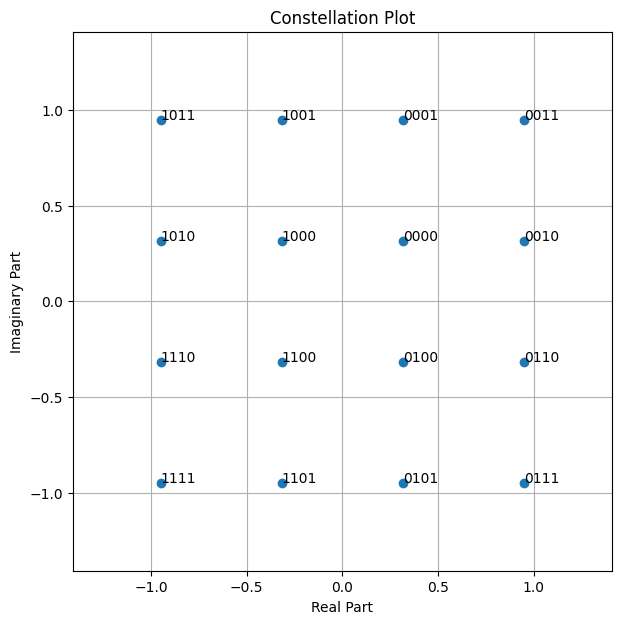

In [47]:
# 测试代码
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 创建一个 QAM 星座
constellation = Constellation(constellation_type="qam", num_bits_per_symbol=4, device=device, trainable=True)
output = constellation(None)  # 前向传播

# 打印星座点
print("Constellation points:")
print(output)
print(output.dtype)

# 显示星座图
constellation.show()

In [57]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# import my_code.mysionna as sn
def gather_pytorch(input_data,  axis=0, indices=None):
    if axis < 0:
        axis = len(input_data.shape) + axis
        
    data = torch.index_select(input_data, axis, indices.flatten())

    shape_input = list(input_data.shape)
    # shape_ = delete(shape_input, axis)
    
    # 连接列表
    shape_output = shape_input[:axis] + \
        list(indices.shape) + shape_input[axis + 1:]

    data_output = data.reshape(shape_output)

    return data_output

def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c

class Constellation(nn.Module):
    def __init__(self,
                 constellation_type,
                 num_bits_per_symbol,
                 initial_value=None,
                 normalize=True,
                 center=False,
                 trainable=False,
                 dtype=torch.complex64,
                 device='cuda',
                 **kwargs):
        super(Constellation, self).__init__()
        assert dtype in [torch.complex64, torch.complex128],\
            "dtype must be torch.complex64 or torch.complex128"
        self.dtype = dtype
        self.device = device

        # 获得 real_dtype
        if dtype == torch.complex64:
            real_dtype = torch.float32
        elif dtype == torch.complex128:
            real_dtype = torch.float64
        else:
            raise TypeError("dtype must be torch.complex64 or torch.complex128")
        # 检查参数异常
        assert constellation_type in ("qam", "pam", "custom"),\
            "Wrong constellation type"
        self._constellation_type = constellation_type

        assert isinstance(normalize, bool), "normalize must be boolean"
        self._normalize = normalize

        assert isinstance(center, bool), "center must be boolean"
        self._center = center

        assert isinstance(trainable, bool), "trainable must be boolean"
        self._trainable = trainable

        assert isinstance(num_bits_per_symbol, (float, int)),\
            "num_bits_per_symbol must be integer"
        assert (num_bits_per_symbol % 1 == 0),\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        #不同的 constellation_type
        if self._constellation_type == "qam":
            assert num_bits_per_symbol % 2 == 0 and num_bits_per_symbol > 0,\
                "num_bits_per_symbol must be a multiple of 2"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "QAM must not have an initial value"
            points = qam(self._num_bits_per_symbol, normalize=self._normalize)
            if not isinstance(points,torch.Tensor):
                points = torch.tensor(points)
            points = points.to(self.dtype).to(self.device)

        elif self._constellation_type == "pam":
            assert num_bits_per_symbol > 0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = num_bits_per_symbol

            assert initial_value is None, "PAM must not have an initial value"
            points = pam(self._num_bits_per_symbol, normalize=self._normalize)
            if not isinstance(points,torch.Tensor):
                points = torch.tensor(points)
            points = points.to(self.dtype).to(self.device)

        elif self._constellation_type == "custom":
            assert num_bits_per_symbol > 0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            if initial_value is None:
                points = torch.rand(2, 2 ** self._num_bits_per_symbol, dtype=real_dtype, device=self.device) * 0.1 - 0.05
                points = torch.complex(points[0], points[1])
            else:
                if not isinstance(initial_value,torch.Tensor):
                    initial_value = torch.tensor(initial_value)
                assert initial_value.dim().numpy()== 1
                assert initial_value.shape[0] == 2 ** num_bits_per_symbol,\
                    "initial_value must have shape [2**num_bits_per_symbol]"
                points = initial_value.to(self.dtype).to(self.device)
        self._points = points

        if self._trainable:
            self._points = nn.Parameter(self._points)
    # pylint: disable=no-self-argument
    def create_or_check_constellation(  constellation_type=None,
                                        num_bits_per_symbol=None,
                                        constellation=None,
                                        dtype=torch.complex64):
        # pylint: disable=line-too-long
        r"""Static method for conviently creating a constellation object or checking that an existing one
        is consistent with requested settings.

        If ``constellation`` is `None`, then this method creates a :class:`~sionna.mapping.Constellation`
        object of type ``constellation_type`` and with ``num_bits_per_symbol`` bits per symbol.
        Otherwise, this method checks that `constellation` is consistent with ``constellation_type`` and
        ``num_bits_per_symbol``. If it is, ``constellation`` is returned. Otherwise, an assertion is raised.

        Input
        ------
        constellation_type : One of ["qam", "pam", "custom"], str
            For "custom", an instance of :class:`~sionna.mapping.Constellation`
            must be provided.

        num_bits_per_symbol : int
            The number of bits per constellation symbol, e.g., 4 for QAM16.
            Only required for ``constellation_type`` in ["qam", "pam"].

        constellation :  Constellation
            An instance of :class:`~sionna.mapping.Constellation` or
            `None`. In the latter case, ``constellation_type``
            and ``num_bits_per_symbol`` must be provided.

        Output
        -------
        : :class:`~sionna.mapping.Constellation`
            A constellation object.
        """
        constellation_object = None
        if constellation is not None:
            assert constellation_type in [None, "custom"], \
                """`constellation_type` must be "custom"."""
            assert num_bits_per_symbol in \
                     [None, constellation.num_bits_per_symbol], \
                """`Wrong value of `num_bits_per_symbol.`"""
            assert constellation.dtype==dtype, \
                "Constellation has wrong dtype."
            constellation_object = constellation
        else:
            assert constellation_type in ["qam", "pam"], \
                "Wrong constellation type."
            assert num_bits_per_symbol is not None, \
                "`num_bits_per_symbol` must be provided."
            constellation_object = Constellation(   constellation_type,
                                                    num_bits_per_symbol,
                                                    dtype=dtype)
        return constellation_object
    def forward(self, x):
        x = self._points
        if self._center:
            x = x - x.mean()
        if self._normalize:
            energy = (x.abs() ** 2).mean()
            energy_sqrt = torch.sqrt(energy).to(self.dtype)
            x = x / energy_sqrt
        return x

    @property
    def normalize(self):
        """Indicates if the constellation is normalized or not."""
        return self._normalize

    @normalize.setter
    def normalize(self, value):
        assert isinstance(value, bool), "`normalize` must be boolean"
        self._normalize = value

    @property
    def center(self):
        """Indicates if the constellation is centered."""
        return self._center

    @center.setter
    def center(self, value):
        assert isinstance(value, bool), "`center` must be boolean"
        self._center = value

    @property
    def num_bits_per_symbol(self):
        """The number of bits per constellation symbol."""
        return self._num_bits_per_symbol
    
    # @property
    # def dtype(self):
    #     return self.dtype

    @property
    def points(self):
        """The (possibly) centered and normalized constellation points."""
        return self(None)

    def show(self, labels=True, figsize=(7,7)):
        """Generate a scatter-plot of the constellation.

        Input
        -----
        labels : bool
            If `True`, the bit labels will be drawn next to each constellation
            point. Defaults to `True`.

        figsize : Two-element Tuple, float
            Width and height in inches. Defaults to `(7,7)`.

        Output
        ------
        : matplotlib.figure.Figure
            A handle to a matplot figure object.
        """
        maxval = self._points.abs().max().item() * 1.05
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_xlim(-maxval, maxval)
        ax.set_ylim(-maxval, maxval)
        points_cpu = self._points.detach().cpu().numpy()
        ax.scatter(points_cpu.real, points_cpu.imag)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("Real Part")
        ax.set_ylabel("Imaginary Part")
        ax.grid(True, which="both", axis="both")
        ax.set_title("Constellation Plot")
        if labels:
            for j, p in enumerate(points_cpu):
                ax.annotate(
                    format(j, f'0{self._num_bits_per_symbol}b'),
                    (p.real, p.imag)
                )
        plt.show()
        
class Mapper(nn.Module):
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 dtype=torch.complex64,
                 device='cuda'):
        super(Mapper, self).__init__()

        assert dtype in [torch.complex64, torch.complex128], "dtype must be torch.complex64 or torch.complex128"

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

        self._return_indices = return_indices
        self.device = device

        self._binary_base = 2**torch.arange(self._constellation.num_bits_per_symbol-1, -1, -1, device=device, dtype=torch.int32)

    @property
    def constellation(self):
        """The Constellation used by the Mapper."""
        return self._constellation

    def forward(self, inputs):
        if not isinstance(inputs,torch.Tensor):
            inputs = torch.tensor(inputs)
        assert inputs.dim() >= 2, "The input must have at least rank 2"

        # Reshape inputs to the desired format
        new_shape = list(inputs.shape[:-1]) + [int(inputs.shape[-1] / self.constellation.num_bits_per_symbol), self.constellation.num_bits_per_symbol]
        inputs_reshaped = inputs.view(new_shape).to(torch.int32)

        # Convert the last dimension to an integer
        int_rep = torch.sum(inputs_reshaped * self._binary_base, dim=-1)
        # Map integers to constellation symbols
        x = gather_pytorch(self.constellation.points,axis=0,indices=int_rep)

        if self._return_indices:
            return x, int_rep
        else:
            return x


In [58]:
class BinarySource(nn.Module):
    """
    Layer generating random binary tensors.

    Parameters
    ----------
    dtype : torch.dtype
        Defines the output datatype of the layer.
        Defaults to `torch.float32`.

    seed : int or None
        Set the seed for the random generator used to generate the bits.
        Set to `None` for random initialization of the RNG.

    device : torch.device or None
        The device on which the tensor will be created.
        Defaults to `None`, which means the tensor will be created on the CPU.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor filled with random binary values.
    """
    def __init__(self, dtype=torch.float32, seed=None, device=None, **kwargs):
        super().__init__(**kwargs)
        self.dtype = dtype
        self._seed = seed
        self.device = device if device is not None else torch.device('cpu')
        self._rng = torch.Generator(device=self.device)
        if self._seed is not None:
            self._rng.manual_seed(self._seed)

    def forward(self, inputs):
        if self._seed is not None:
            return torch.randint(0, 2, tuple(inputs.tolist()), generator=self._rng, dtype=torch.int32, device=self.device).to(self.dtype)
        else:
            return torch.randint(0, 2, tuple(inputs.tolist()), dtype=torch.int32, device=self.device).to(self.dtype)

class SymbolSource(nn.Module):
    """
    Layer generating a tensor of arbitrary shape filled with random constellation symbols.
    Optionally, the symbol indices and/or binary representations of the
    constellation symbols can be returned.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation :  Constellation
        An instance of :class:`~sionna.mapping.Constellation` or
        `None`. In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    return_indices : bool
        If enabled, the function also returns the symbol indices.
        Defaults to `False`.

    return_bits : bool
        If enabled, the function also returns the binary symbol
        representations (i.e., bit labels).
        Defaults to `False`.

    seed : int or None
        The seed for the random generator.
        `None` leads to a random initialization of the RNG.
        Defaults to `None`.

    dtype : One of [torch.complex64, torch.complex128], torch.dtype
        The output dtype. Defaults to torch.complex64.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    symbols : ``shape``, ``dtype``
        Tensor filled with random symbols of the chosen ``constellation_type``.

    symbol_indices : ``shape``, torch.int32
        Tensor filled with the symbol indices.
        Only returned if ``return_indices`` is `True`.

    bits : [``shape``, ``num_bits_per_symbol``], torch.int32
        Tensor filled with the binary symbol representations (i.e., bit labels).
        Only returned if ``return_bits`` is `True`.
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 return_bits=False,
                 seed=None,
                 dtype=torch.complex64,
                 device= "cuda",
                 **kwargs):
        super().__init__(**kwargs)
        constellation = Constellation.create_or_check_constellation(
            constellation_type,
            num_bits_per_symbol,
            constellation,
            dtype=dtype)
        
        if dtype ==torch.complex32:
            real_dtype = torch.float16
        elif dtype == torch.complex64:
            real_dtype = torch.float32
        elif dtype == torch.complex128:
            real_dtype = torch.float64
        else:
            raise TypeError("real_dtype must be in [torch.float16,torch.float32,torch.float64]")
        self._num_bits_per_symbol = constellation.num_bits_per_symbol
        self._return_indices = return_indices
        self._return_bits = return_bits
        self._binary_source = BinarySource(seed=seed, dtype=real_dtype,device=device)
        self._mapper = Mapper(constellation=constellation,
                              return_indices=return_indices,
                              dtype=dtype,
                              device=device)

    def forward(self, inputs):
        shape = torch.cat([inputs, torch.tensor([self._num_bits_per_symbol])], dim=-1)
        b = self._binary_source(shape.to(torch.int32))
        if self._return_indices:
            x, ind = self._mapper(b)
        else:
            x = self._mapper(b)

        result = x.squeeze(-1)
        if self._return_indices or self._return_bits:
            result = [result]
        if self._return_indices:
            result.append(ind.squeeze(-1))
        if self._return_bits:
            result.append(b)

        return result



In [69]:
# 定义测试函数
def test_symbol_source():
    # 初始化参数
    constellation_type = "qam"
    num_bits_per_symbol = 4
    return_indices = True
    return_bits = True
    seed = 42
    dtype = torch.complex64
    output_shape = [2, 3]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 创建 SymbolSource 实例
    symbol_source = SymbolSource(
        constellation_type=constellation_type,
        num_bits_per_symbol=num_bits_per_symbol,
        return_indices=return_indices,
        return_bits=return_bits,
        seed=seed,
        dtype=dtype,
        device= device
    )

    # 执行前向传播
    inputs = torch.tensor(output_shape, dtype=torch.int32)
    outputs = symbol_source(inputs)

    # 输出结果
    print(f"Symbols: {outputs[0]}")
    if return_indices:
        print(f"Indices: {outputs[1]}")
    if return_bits:
        print(f"Bits: {outputs[2]}")

# 运行测试函数
test_symbol_source()

Symbols: tensor([[-0.3162-0.3162j, -0.3162-0.3162j,  0.9487-0.9487j],
        [-0.9487+0.3162j,  0.3162-0.9487j, -0.9487+0.9487j]], device='cuda:0')
Indices: tensor([[12, 12,  7],
        [10,  5, 11]], device='cuda:0')
Bits: tensor([[[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [0., 1., 1., 1.]],

        [[1., 0., 1., 0.],
         [0., 1., 0., 1.],
         [1., 0., 1., 1.]]], device='cuda:0')


# tensorflow

Constellation points: tf.Tensor(
[ 0.54232615+0.j  0.7592566 +0.j  0.32539567+0.j  0.10846523+0.j
  1.1931175 +0.j  0.97618705+0.j  1.410048  +0.j  1.6269784 +0.j
 -0.54232615+0.j -0.7592566 +0.j -0.32539567+0.j -0.10846523+0.j
 -1.1931175 +0.j -0.97618705+0.j -1.410048  +0.j -1.6269784 +0.j], shape=(16,), dtype=complex64)


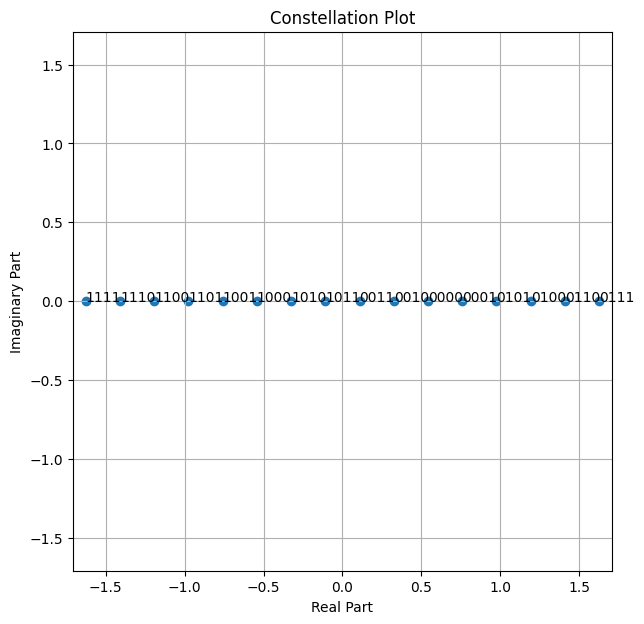

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt

import sionna as sn

def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c

class Constellation(Layer):
    # pylint: disable=line-too-long
    r"""
    Constellation(constellation_type, num_bits_per_symbol, initial_value=None, normalize=True, center=False, trainable=False, dtype=tf.complex64, **kwargs)

    Constellation that can be used by a (de)mapper.

    This class defines a constellation, i.e., a complex-valued vector of
    constellation points. A constellation can be trainable. The binary
    representation of the index of an element of this vector corresponds
    to the bit label of the constellation point. This implicit bit
    labeling is used by the ``Mapper`` and ``Demapper`` classes.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", the constellation points are randomly initialized
        if no ``initial_value`` is provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    initial_value : :math:`[2^\text{num_bits_per_symbol}]`, NumPy array or Tensor
        Initial values of the constellation points. If ``normalize`` or
        ``center`` are `True`, the initial constellation might be changed.

    normalize : bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    center : bool
        If `True`, the constellation is ensured to have zero mean.
        Defaults to `False`.

    trainable : bool
        If `True`, the constellation points are trainable variables.
        Defaults to `False`.

    dtype : [tf.complex64, tf.complex128], tf.DType
        The dtype of the constellation.

    Output
    ------
    : :math:`[2^\text{num_bits_per_symbol}]`, ``dtype``
        The constellation.

    Note
    ----
    One can create a trainable PAM/QAM constellation. This is
    equivalent to creating a custom trainable constellation which is
    initialized with PAM/QAM constellation points.
    """
    # pylint: enable=C0301

    def __init__(self,
                 constellation_type,
                 num_bits_per_symbol,
                 initial_value=None,
                 normalize=True,
                 center=False,
                 trainable=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(**kwargs)
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"
        self._dtype = dtype

        assert constellation_type in ("qam", "pam", "custom"),\
            "Wrong constellation type"
        self._constellation_type = constellation_type

        assert isinstance(normalize, bool), "normalize must be boolean"
        self._normalize = normalize

        assert isinstance(center, bool), "center must be boolean"
        self._center = center

        assert isinstance(trainable, bool), "trainable must be boolean"
        self._trainable = trainable

        # allow float inputs that represent int
        assert isinstance(num_bits_per_symbol, (float,int)),\
            "num_bits_per_symbol must be integer"
        assert (num_bits_per_symbol%1==0),\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        if self._constellation_type=="qam":
            assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
                "num_bits_per_symbol must be a multiple of 2"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "QAM must not have an initial value"
            points = qam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="pam":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            assert initial_value is None, "PAM must not have an initial value"
            points = pam(self._num_bits_per_symbol, normalize=self.normalize)
            points = tf.cast(points, self._dtype)

        if self._constellation_type=="custom":
            assert num_bits_per_symbol>0,\
                "num_bits_per_symbol must be integer"
            self._num_bits_per_symbol = int(num_bits_per_symbol)

            # Randomly initialize points if no initial_value is provided
            if initial_value is None:
                points = tf.random.uniform(  # pylint: disable=E1123
                                        [2, 2**self._num_bits_per_symbol],
                                        minval=-0.05, maxval=0.05,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
                points  = tf.complex(points[0], points[1])
            else:
                assert tf.rank(initial_value).numpy() == 1
                assert tf.shape(initial_value)[0] == 2**num_bits_per_symbol,\
                    "initial_value must have shape [2**num_bits_per_symbol]"
                points = tf.cast(initial_value, self._dtype)
        self._points = points

    def build(self, input_shape): #pylint: disable=unused-argument
        points = self._points
        points = tf.stack([tf.math.real(points),
                           tf.math.imag(points)], axis=0)
        if self._trainable:
            self._points = tf.Variable(points,
                                       trainable=self._trainable,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)
        else:
            self._points = tf.constant(points,
                                    dtype=tf.as_dtype(self._dtype).real_dtype)

    # pylint: disable=no-self-argument
    def create_or_check_constellation(  constellation_type=None,
                                        num_bits_per_symbol=None,
                                        constellation=None,
                                        dtype=tf.complex64):
        # pylint: disable=line-too-long
        r"""Static method for conviently creating a constellation object or checking that an existing one
        is consistent with requested settings.

        If ``constellation`` is `None`, then this method creates a :class:`~sionna.mapping.Constellation`
        object of type ``constellation_type`` and with ``num_bits_per_symbol`` bits per symbol.
        Otherwise, this method checks that `constellation` is consistent with ``constellation_type`` and
        ``num_bits_per_symbol``. If it is, ``constellation`` is returned. Otherwise, an assertion is raised.

        Input
        ------
        constellation_type : One of ["qam", "pam", "custom"], str
            For "custom", an instance of :class:`~sionna.mapping.Constellation`
            must be provided.

        num_bits_per_symbol : int
            The number of bits per constellation symbol, e.g., 4 for QAM16.
            Only required for ``constellation_type`` in ["qam", "pam"].

        constellation :  Constellation
            An instance of :class:`~sionna.mapping.Constellation` or
            `None`. In the latter case, ``constellation_type``
            and ``num_bits_per_symbol`` must be provided.

        Output
        -------
        : :class:`~sionna.mapping.Constellation`
            A constellation object.
        """
        constellation_object = None
        if constellation is not None:
            assert constellation_type in [None, "custom"], \
                """`constellation_type` must be "custom"."""
            assert num_bits_per_symbol in \
                     [None, constellation.num_bits_per_symbol], \
                """`Wrong value of `num_bits_per_symbol.`"""
            assert constellation.dtype==dtype, \
                "Constellation has wrong dtype."
            constellation_object = constellation
        else:
            assert constellation_type in ["qam", "pam"], \
                "Wrong constellation type."
            assert num_bits_per_symbol is not None, \
                "`num_bits_per_symbol` must be provided."
            constellation_object = Constellation(   constellation_type,
                                                    num_bits_per_symbol,
                                                    dtype=dtype)
        return constellation_object

    def call(self, inputs): #pylint: disable=unused-argument
        x = self._points
        x = tf.complex(x[0], x[1])
        if self._center:
            x = x - tf.reduce_mean(x)
        if self._normalize:
            energy = tf.reduce_mean(tf.square(tf.abs(x)))
            energy_sqrt = tf.cast(tf.sqrt(energy), self._dtype)
            x = x / energy_sqrt
        return x

    @property
    def normalize(self):
        """Indicates if the constellation is normalized or not."""
        return self._normalize

    @normalize.setter
    def normalize(self, value):
        assert isinstance(value, bool), "`normalize` must be boolean"
        self._normalize = value

    @property
    def center(self):
        """Indicates if the constellation is centered."""
        return self._center

    @center.setter
    def center(self, value):
        assert isinstance(value, bool), "`center` must be boolean"
        self._center = value

    @property
    def num_bits_per_symbol(self):
        """The number of bits per constellation symbol."""
        return self._num_bits_per_symbol

    @property
    def points(self):
        """The (possibly) centered and normalized constellation points."""
        return self(None)

    def show(self, labels=True, figsize=(7,7)):
        """Generate a scatter-plot of the constellation.

        Input
        -----
        labels : bool
            If `True`, the bit labels will be drawn next to each constellation
            point. Defaults to `True`.

        figsize : Two-element Tuple, float
            Width and height in inches. Defaults to `(7,7)`.

        Output
        ------
        : matplotlib.figure.Figure
            A handle to a matplot figure object.
        """
        maxval = np.max(np.abs(self.points))*1.05
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        plt.xlim(-maxval, maxval)
        plt.ylim(-maxval, maxval)
        plt.scatter(np.real(self.points), np.imag(self.points))
        ax.set_aspect("equal", adjustable="box")
        plt.xlabel("Real Part")
        plt.ylabel("Imaginary Part")
        plt.grid(True, which="both", axis="both")
        plt.title("Constellation Plot")
        if labels is True:
            for j, p in enumerate(self.points.numpy()):
                plt.annotate(
                    np.binary_repr(j, self.num_bits_per_symbol),
                    (np.real(p), np.imag(p))
                )
        # return fig
# 创建一个 QAM 星座
constellation = Constellation(constellation_type="pam", num_bits_per_symbol=4, trainable=True)

# 前向传播
output = constellation(None)

# 打印星座点
print("Constellation points:", output)

# 显示星座图
constellation.show()

In [72]:
class Mapper(Layer):
    # pylint: disable=line-too-long
    r"""
    Mapper(constellation_type=None, num_bits_per_symbol=None, constellation=None, return_indices=False, dtype=tf.complex64, **kwargs)

    Maps binary tensors to points of a constellation.

    This class defines a layer that maps a tensor of binary values
    to a tensor of points from a provided constellation.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation :  Constellation
        An instance of :class:`~sionna.mapping.Constellation` or
        `None`. In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    return_indices : bool
        If enabled, symbol indices are additionally returned.
        Defaults to `False`.

    dtype : One of [tf.complex64, tf.complex128], tf.DType
        The output dtype. Defaults to tf.complex64.

    Input
    -----
    : [..., n], tf.float or tf.int
        Tensor with with binary entries.

    Output
    ------
    : [...,n/Constellation.num_bits_per_symbol], tf.complex
        The mapped constellation symbols.

    : [...,n/Constellation.num_bits_per_symbol], tf.int32
        The symbol indices corresponding to the constellation symbols.
        Only returned if ``return_indices`` is set to True.


    Note
    ----
    The last input dimension must be an integer multiple of the
    number of bits per constellation symbol.
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 dtype=tf.complex64,
                 **kwargs
                ):
        super().__init__(dtype=dtype, **kwargs)
        assert dtype in [tf.complex64, tf.complex128],\
            "dtype must be tf.complex64 or tf.complex128"

        # Create constellation object
        self._constellation = Constellation.create_or_check_constellation(
                                                        constellation_type,
                                                        num_bits_per_symbol,
                                                        constellation,
                                                        dtype=dtype)

        self._return_indices = return_indices

        self._binary_base = 2**tf.constant(
                        range(self.constellation.num_bits_per_symbol-1,-1,-1))

    @property
    def constellation(self):
        """The Constellation used by the Mapper."""
        return self._constellation

    def call(self, inputs):
        tf.debugging.assert_greater_equal(tf.rank(inputs), 2,
            message="The input must have at least rank 2")

        # Reshape inputs to the desired format
        new_shape = [-1] + inputs.shape[1:-1].as_list() + \
           [int(inputs.shape[-1] / self.constellation.num_bits_per_symbol),
            self.constellation.num_bits_per_symbol]
        inputs_reshaped = tf.cast(tf.reshape(inputs, new_shape), tf.int32)

        # Convert the last dimension to an integer
        int_rep = tf.reduce_sum(inputs_reshaped * self._binary_base, axis=-1)

        # Map integers to constellation symbols
        x = tf.gather(self.constellation.points, int_rep, axis=0)
        # print(f"inputs:{self.constellation.points}")
        # print(f"indices{int_rep}")

        if self._return_indices:
            return x, int_rep
        else:
            return x
# 创建一个 QAM 星座
constellation = Constellation(constellation_type="custom", num_bits_per_symbol=4, dtype=tf.complex64)

# 创建一个 Mapper
mapper = Mapper(constellation_type="custom", num_bits_per_symbol=4, constellation=constellation,return_indices=True, dtype=tf.complex64)

# 输入数据（示例：16个比特位）
inputs = tf.random.uniform((1, 16), minval=0, maxval=2, dtype=tf.int32)

# 前向传播
output, indices = mapper(inputs)

# 打印结果
print("Mapped symbols:", output.numpy())
print("Symbol indices:", indices.numpy())

Mapped symbols: [[-0.80513924+0.25560096j -0.3638259 -0.8026957j  -0.41403392+0.16252203j
   0.71347237-0.53906804j]]
Symbol indices: [[ 8 14  4  3]]


In [73]:
class BinarySource(Layer):
    """BinarySource(dtype=tf.float32, seed=None, **kwargs)

    Layer generating random binary tensors.

    Parameters
    ----------
    dtype : tf.DType
        Defines the output datatype of the layer.
        Defaults to `tf.float32`.

    seed : int or None
        Set the seed for the random generator used to generate the bits.
        Set to `None` for random initialization of the RNG.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor filled with random binary values.
    """
    def __init__(self, dtype=tf.float32, seed=None, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._seed = seed
        if self._seed is not None:
            self._rng = tf.random.Generator.from_seed(self._seed)

    def call(self, inputs):
        if self._seed is not None:
            return tf.cast(self._rng.uniform(inputs, 0, 2, tf.int32),
                           dtype=super().dtype)
        else:
            return tf.cast(tf.random.uniform(inputs, 0, 2, tf.int32),
                           dtype=super().dtype)
class SymbolSource(Layer):
    # pylint: disable=line-too-long
    r"""SymbolSource(constellation_type=None, num_bits_per_symbol=None, constellation=None, return_indices=False, return_bits=False, seed=None, dtype=tf.complex64, **kwargs)

    Layer generating a tensor of arbitrary shape filled with random constellation symbols.
    Optionally, the symbol indices and/or binary representations of the
    constellation symbols can be returned.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation :  Constellation
        An instance of :class:`~sionna.mapping.Constellation` or
        `None`. In the latter case, ``constellation_type``
        and ``num_bits_per_symbol`` must be provided.

    return_indices : bool
        If enabled, the function also returns the symbol indices.
        Defaults to `False`.

    return_bits : bool
        If enabled, the function also returns the binary symbol
        representations (i.e., bit labels).
        Defaults to `False`.

    seed : int or None
        The seed for the random generator.
        `None` leads to a random initialization of the RNG.
        Defaults to `None`.

    dtype : One of [tf.complex64, tf.complex128], tf.DType
        The output dtype. Defaults to tf.complex64.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    symbols : ``shape``, ``dtype``
        Tensor filled with random symbols of the chosen ``constellation_type``.

    symbol_indices : ``shape``, tf.int32
        Tensor filled with the symbol indices.
        Only returned if ``return_indices`` is `True`.

    bits : [``shape``, ``num_bits_per_symbol``], tf.int32
        Tensor filled with the binary symbol representations (i.e., bit labels).
        Only returned if ``return_bits`` is `True`.
    """
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 return_bits=False,
                 seed=None,
                 dtype=tf.complex64,
                 **kwargs
                ):
        super().__init__(dtype=dtype, **kwargs)
        constellation = Constellation.create_or_check_constellation(
            constellation_type,
            num_bits_per_symbol,
            constellation,
            dtype)
        self._num_bits_per_symbol = constellation.num_bits_per_symbol
        self._return_indices = return_indices
        self._return_bits = return_bits
        self._binary_source = BinarySource(seed=seed, dtype=dtype.real_dtype)
        self._mapper = Mapper(constellation=constellation,
                              return_indices=return_indices,
                              dtype=dtype)

    def call(self, inputs):
        shape = tf.concat([inputs, [self._num_bits_per_symbol]], axis=-1)
        b = self._binary_source(tf.cast(shape, tf.int32))
        if self._return_indices:
            x, ind = self._mapper(b)
        else:
            x = self._mapper(b)

        result = tf.squeeze(x, -1)
        if self._return_indices or self._return_bits:
            result = [result]
        if self._return_indices:
            result.append(tf.squeeze(ind, -1))
        if self._return_bits:
            result.append(b)

        return result

In [75]:
# 测试代码
def test_symbol_source():
    # 初始化参数
    constellation_type = "qam"
    num_bits_per_symbol = 4
    return_indices = True
    return_bits = True
    seed = 42
    dtype = tf.complex64
    output_shape = [2, 3]

    # 创建 SymbolSource 实例
    symbol_source = SymbolSource(
        constellation_type=constellation_type,
        num_bits_per_symbol=num_bits_per_symbol,
        return_indices=return_indices,
        return_bits=return_bits,
        seed=seed,
        dtype=dtype
    )

    # 执行前向传播
    inputs = tf.constant(output_shape, dtype=tf.int32)
    outputs = symbol_source(inputs)

    # 输出结果
    print(f"Symbols: {outputs[0]}")
    if return_indices:
        print(f"Indices: {outputs[1]}")
    if return_bits:
        print(f"Bits: {outputs[2]}")

# 运行测试函数
test_symbol_source()

Symbols: [[-0.3162278-0.3162278j  0.9486833-0.9486833j  0.9486833-0.3162278j]
 [ 0.9486833-0.3162278j  0.3162278-0.9486833j -0.3162278-0.9486833j]]
Indices: [[12  7  6]
 [ 6  5 13]]
Bits: [[[1. 1. 0. 0.]
  [0. 1. 1. 1.]
  [0. 1. 1. 0.]]

 [[0. 1. 1. 0.]
  [0. 1. 0. 1.]
  [1. 1. 0. 1.]]]
